In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor


In [2]:
import numpy as np
import pretty_midi as pyd
from tqdm import tqdm

In [273]:
def convert_to_2D(analyze_file : pyd.PrettyMIDI, min_pitch: int, max_pitch: int):
    n_ticks = analyze_file.time_to_tick(analyze_file.get_end_time())+1
    res = np.zeros((128,n_ticks),int)
    for i in range(len(analyze_file.instruments)):
        for note in analyze_file.instruments[i].notes:
            tick_start = analyze_file.time_to_tick(note.start)
            tick_end = analyze_file.time_to_tick(note.end)
            for j in range(tick_start,tick_end+1):
                res[note.pitch][j]=1
    return res[min_pitch:max_pitch]

def convert_to_2D_one_instrument(analyze_file : pyd.PrettyMIDI, i:int, min_pitch: int, max_pitch: int):
    n_ticks = analyze_file.time_to_tick(analyze_file.get_end_time())+1
    res = np.zeros((128,n_ticks),int)
    for note in analyze_file.instruments[i].notes:
        tick_start = analyze_file.time_to_tick(note.start)
        tick_end = analyze_file.time_to_tick(note.end)
        for j in range(tick_start,tick_end+1):
            res[note.pitch][j]=1
    return res[min_pitch:max_pitch]


def convert_to_2D_compressed(analyze_file : pyd.PrettyMIDI, min_pitch: int, max_pitch: int, compression: int):
    '''compression pour ne pas avoir des fichiers trop longs'''
    n_ticks = analyze_file.time_to_tick(analyze_file.get_end_time())+1
    res = np.zeros((128,int(np.ceil(n_ticks/compression))+1),int)
    for i in range(len(analyze_file.instruments)):
        for note in analyze_file.instruments[i].notes:
            tick_start = int(np.floor(analyze_file.time_to_tick(note.start)/compression))
            tick_end = int(np.ceil(analyze_file.time_to_tick(note.end)/compression))
            for j in range(tick_start,tick_end+1):
                res[note.pitch][j]=1
    return res[min_pitch:max_pitch]


def convert_to_2D_compressed_v2(analyze_file : pyd.PrettyMIDI, min_pitch: int, max_pitch: int, compression: int):
    '''compression pour ne pas avoir des fichiers trop longs + décompte de la longueur de la note (plus forcément 0-1)'''
    n_ticks = analyze_file.time_to_tick(analyze_file.get_end_time())+1
    res = np.zeros((128,int(np.ceil(n_ticks/compression))+1),int)
    for i in range(len(analyze_file.instruments)):
        for note in analyze_file.instruments[i].notes:
            tick_start = int(np.floor(analyze_file.time_to_tick(note.start)/compression))
            tick_end = int(np.ceil(analyze_file.time_to_tick(note.end)/compression))
            for j in range(tick_start,tick_end+1):
                res[note.pitch][j]=j-tick_start+1
    return res[min_pitch:max_pitch]


def generate_training_samples(X: np.ndarray,lookback : int):
    '''créer des trainings samples de longueur temporelle lookback'''
    X_train = []
    Y_train = []
    _,t = X.shape
    for i in range(t-lookback-1):
        X_train.append(np.transpose(X[:,i:i+lookback]))
        Y_train.append(np.transpose(X[:,i+1:i+1+lookback]))
    return torch.tensor(np.array(X_train)),torch.tensor(np.array(Y_train))

In [76]:
# un seul fichier
file_midi = pyd.PrettyMIDI("Modified_data/yesterday.mid")
file_array = convert_to_2D(file_midi,23,94)
file_array = convert_to_2D_compressed(file_midi,23,94,20)
X_train, Y_train = generate_training_samples(file_array,200)
loader = DataLoader(TensorDataset(X_train, Y_train), batch_size= 5, shuffle=True)
file_array.shape

(71, 4546)

In [89]:
# un seul fichier
file_midi = pyd.PrettyMIDI("Modified_data/hey_jude.mid")
file_array = convert_to_2D(file_midi,23,94)
file_array = convert_to_2D_compressed(file_midi,23,94,int(1/(file_midi.tick_to_time(1)*36)))
X_train, Y_train = generate_training_samples(file_array,200)
loader = DataLoader(TensorDataset(X_train, Y_train), batch_size= 5, shuffle=True)
file_array.shape

(71, 10625)

In [310]:
def keep_instruments(file: pyd.PrettyMIDI):
    '''fonction qui définit quels instruments sont pertinentS. Les critères sont assez archaïques et les résultats à démontrer. 
    L'intérêt est d'éviter de devoir faire le tri à la min en amont'''
    conv=[]
    n_notes = []
    for i in range(len(file.instruments)):
        conv.append(convert_to_2D_one_instrument(file,i,23,94))
        n_notes.append(len(file.instruments[i].notes))
    res = [True for _ in range(len(file.instruments))]
    for i in range(len(file.instruments)):
        if(file.instruments[i].is_drum):
            res[i] = False
        if(file.instruments[i].program in (np.arange(96,104))):
            res[i] = False
        length=[]
        start_times=[]
        end_times=[]
        for note in file.instruments[i].notes:
            length.append(note.end-note.start)
            start_times.append(note.start)
            end_times.append(note.end)
        if(np.mean(length)>2):
            res[i] = False
        if(n_notes[i]<10):
            res[i] = False
        if(np.median(length)>2):
            res[i] = False
        if ((np.max(np.unique(start_times,return_counts=True)[1])>3)&(np.mean(length)>1)):
            res[i] = False
        if ((np.max(np.unique(end_times,return_counts=True)[1])>3)&(np.mean(length)>1)):
            res[i] = False
        for j in range(i+1,len(file.instruments)):
            sup = np.sum(np.where(conv[i]+conv[j]==2,1,0))
            n_i = np.sum(np.where(conv[i]==1,1,0))
            n_j = np.sum(np.where(conv[j]==1,1,0))
            if (sup>0.1*max(n_i,n_j)):
                if (np.argmin([n_i,n_j]==0)):
                    res[i]=False
                else:
                    res[j]=False
    return res

In [311]:
# tous les fichiers d'un dossier
from os import listdir
origin_dir = "Data/Black Eyed Peas/"
#aussi essayé avec Modified_data/beatles pour les créations dites beatles
files_name = listdir(origin_dir)
files_midi = []
X_train,Y_train = [], []
compression_rate = []
for file_name in files_name:
    file_midi = pyd.PrettyMIDI(origin_dir+file_name)
    keep_instrument_index = keep_instruments(file_midi)
    file_midi.instruments = [m for bool_val,m in zip(keep_instrument_index,file_midi.instruments) if bool_val]
    compression = int(1/(file_midi.tick_to_time(1)*36))
    file_array = convert_to_2D_compressed_v2(file_midi,23,94,compression)
    X_train_file, Y_train_file = generate_training_samples(file_array,200)
    print(X_train_file.shape)
    if(X_train_file.size(0)>1000):
        perm = torch.randperm(X_train_file.size(0))
        idx = perm[:1000]
        X_train_file = X_train_file[idx]
        Y_train_file = Y_train_file[idx]
    X_train.append(X_train_file)
    Y_train.append(Y_train_file)
    compression_rate.append(compression)
    files_midi.append(file_midi)
X_train = torch.concat(X_train)
Y_train = torch.concat(Y_train)
Y_train_v2 = Y_train.clone()
Y_train_v2[Y_train_v2>0] = 1
loader = DataLoader(TensorDataset(X_train, Y_train_v2), batch_size= 5, shuffle=True)

torch.Size([7668, 200, 71])
torch.Size([7462, 200, 71])
torch.Size([9567, 200, 71])
torch.Size([13378, 200, 71])
torch.Size([9143, 200, 71])
torch.Size([10939, 200, 71])
torch.Size([9733, 200, 71])
torch.Size([7863, 200, 71])
torch.Size([10405, 200, 71])
torch.Size([10425, 200, 71])
torch.Size([9413, 200, 71])
torch.Size([8019, 200, 71])
torch.Size([8410, 200, 71])
torch.Size([11060, 200, 71])
torch.Size([11085, 200, 71])
torch.Size([10756, 200, 71])
torch.Size([9197, 200, 71])
torch.Size([1474, 200, 71])


In [317]:
# classe non utilisée pour débugger
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x[0].shape)
        print(len(x[1]))
        return x



# Le réseau utilisé. J'ai essayé d'ajouter une layer avec le LSTM. Surement à retirer 
class LSTM_Network(nn.Module):
    def __init__(self,n_hidden):
        super().__init__()
        n_batch = 5
        self.lin1 = nn.Linear(71,71)
        self.LSTM = nn.LSTM(input_size= 71, hidden_size = n_hidden, bias=True, batch_first=True)
        self.lin = nn.Linear(n_hidden,71)
        self.sig = nn.Sigmoid()

    def forward(self, x: np.ndarray):
        # x = self.flatten(x)
        # output, (self.h0,self.c0) = self.LSTM(x,(self.h0,self.c0))
        output = self.lin1(x)
        output, _ = self.LSTM(output)
        # output, _ = self.LSTM(x,(self.h0,self.c0))
        # print(self.h0)
        # print(self.c0)
        output = self.lin(output)
        # print(output)
        output = self.sig(output)
        # print(output)
        # s = self.lin(output)
        # output = torch.exp(s)/(torch.exp(s)+torch.exp(torch.neg(s)))
        return output
    
def generate_training_samples(X: np.ndarray,lookback : int):
    X_train = []
    Y_train = []
    _,t = X.shape
    for i in range(t-lookback-1):
        X_train.append(np.transpose(X[:,i:i+lookback]))
        Y_train.append(np.transpose(X[:,i+1:i+1+lookback]))
    return torch.tensor(np.array(X_train)),torch.tensor(np.array(Y_train))

In [129]:
# loss function maison pour avoir une pénalité quand c'est bien et quand c'est pas bien. On peut peut être essayé de pénaliser davantage un faux négatif en ajoutant un coefficient
class CustomLoss(torch.autograd.Function):

    @staticmethod
    def forward(ctx, y, p_input):
        p = p_input.clone()
        p[p<1e-5] = 1e-5
        p[p>1-1e-5] = 1-1e-5
        ctx.save_for_backward(y,p)
        n_batch = y.size()[1]
        # print((-y*torch.log(p)-(1-y)*torch.log(1-p)).shape)
        res = torch.sum(-y*torch.log(p)-(1-y)*torch.log(1-p),(1,2))
        # res = torch.sum(-y*torch.log(p)-(1-y)*torch.log(1-p))
        # print(res.shape)
        return res/n_batch
    
    @staticmethod
    def backward(ctx, grad_output):
        y,p = ctx.saved_tensors
        # print(y.shape,"a")
        grad_input = grad_output.clone()
        grad_input = torch.neg(y/p-(1-y)/(1-p))
        # print(grad_input)
        # print(grad_input.shape,"b")
        return None, grad_input


In [318]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
model = LSTM_Network(256).to(device)
print(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #AdamW le meilleur

Using cpu device
LSTM_Network(
  (lin1): Linear(in_features=71, out_features=71, bias=True)
  (LSTM): LSTM(71, 256, batch_first=True)
  (lin): Linear(in_features=256, out_features=71, bias=True)
  (sig): Sigmoid()
)


```python
loss_arr = []
model.train()
X_batch, Y_batch = loader.dataset.tensors[0][100],loader.dataset.tensors[1][100]
X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
for i in range(200):
    myloss = CustomLoss.apply
    y_pred = model(X_batch.float())
    loss = myloss(Y_batch.float(),y_pred)
    # print(loss)
    optimizer.zero_grad()
    loss.backward(torch.ones_like(loss))
    optimizer.step()
    loss_arr.append(loss.sum().item())
    if i % 1 == 0:
        loss, current = loss.sum(), (i + 1) * len(X_batch)
        print(f"loss: {loss:>7f}  [{current:>5d}/{len(X_train):>5d}]")

Boucle d'apprentissage:

In [319]:
loss_arr = []
smooth_loss_arr = []
model.train()
n_epoch = 10
for j in range(n_epoch):
    for batch,(X_batch,Y_batch) in enumerate(loader):
        myloss = CustomLoss.apply
        # X_batch, Y_batch = loader.dataset.tensors[0][100],loader.dataset.tensors[1][100]
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        y_pred = model(X_batch.float())
        loss = myloss(Y_batch.float(),y_pred)
        # print(loss)
        optimizer.zero_grad()
        loss.backward(torch.ones_like(loss),retain_graph=False)
        optimizer.step()
        loss_arr.append(loss.sum().item())
        if(batch+j==0):
            smooth_loss = loss.sum().item()
        else:
            smooth_loss = 0.999*smooth_loss + 0.001*loss.sum().item()
        smooth_loss_arr.append(smooth_loss)
        if batch % 100 == 0:
            loss, current = loss.sum(), (batch + 1) * len(X_batch)+j*len(X_train)
            print(f"loss: {loss:>7f} \t smooth loss: {smooth_loss:>7f} \t [{current:>5d}/{len(X_train)*n_epoch:>5d}]")

loss: 246.408478 	 smooth loss: 246.408478 	 [    5/180000]
loss: 50.391212 	 smooth loss: 229.064653 	 [  505/180000]
loss: 33.362610 	 smooth loss: 211.054809 	 [ 1005/180000]
loss: 23.526342 	 smooth loss: 194.028329 	 [ 1505/180000]
loss: 28.516886 	 smooth loss: 178.131075 	 [ 2005/180000]
loss: 19.722675 	 smooth loss: 163.349565 	 [ 2505/180000]
loss: 22.374166 	 smooth loss: 149.735366 	 [ 3005/180000]
loss: 21.322596 	 smooth loss: 137.272222 	 [ 3505/180000]
loss: 20.460806 	 smooth loss: 125.820171 	 [ 4005/180000]
loss: 10.817118 	 smooth loss: 115.390168 	 [ 4505/180000]
loss: 8.465799 	 smooth loss: 105.905169 	 [ 5005/180000]
loss: 13.221150 	 smooth loss: 97.172703 	 [ 5505/180000]
loss: 11.352675 	 smooth loss: 89.238059 	 [ 6005/180000]
loss: 14.860221 	 smooth loss: 81.972571 	 [ 6505/180000]
loss: 11.755057 	 smooth loss: 75.340422 	 [ 7005/180000]
loss: 13.983464 	 smooth loss: 69.272585 	 [ 7505/180000]
loss: 12.129282 	 smooth loss: 63.862927 	 [ 8005/180000]
los

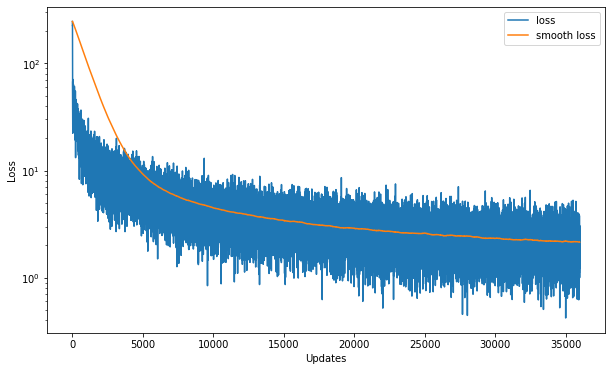

In [320]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])
plt.plot(loss_arr, label="loss")
plt.plot(smooth_loss_arr, label="smooth loss")
plt.yscale('log')
plt.xlabel("Updates")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [40]:
def generate_csv_file(tensor : torch.Tensor):
    np.savetxt("LSTM_",np.array(tensor))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# Génération de musique

In [199]:
from os import listdir

def Generate_music_from_sample(network : nn.modules, batch_reference: torch.Tensor, n :int, name: str):
    '''On part d'un batch existant et on le complète en ajoutant la sortie du LSTM. On remet ensuite les 200 (taille du LSTM) dernières "secondes" pour générer le suivant'''
    network.eval()
    n_init = batch_reference.shape[0]
    final_length = n
    res = torch.zeros((final_length,71))
    res[:n_init] = batch_reference
    with torch.no_grad():
        for i in range(n_init,n):
            input = res[i-n_init:i]
            output = network(input)
            res[i] = torch.bernoulli(output[-1])
            if(i>0):
                res[i][res[i]>0] = res[i][res[i]>0]+1
    res[res>0] = 1
    res = np.transpose(np.array(res))
    n_file = len(listdir("Generated_music/"))
    np.savetxt("Generated_music/"+name+str(n_file)+"_length_"+str(n)+".csv",res,"%i")
    inv_compression = 20
    output = pyd.PrettyMIDI(resolution=inv_compression)
    output.instruments = []
    pitchs = np.arange(23,93)
    instru = pyd.Instrument(0)
    for i in range(len(pitchs)):
        to_analyze = res[i]
        to_analyze_trick = np.concatenate([to_analyze,[0]])-np.concatenate([[0],to_analyze])
        starting_ticks = np.argwhere(to_analyze_trick==1).astype(int)
        ending_ticks = np.argwhere(to_analyze_trick==-1).astype(int)
        for start,end in zip(starting_ticks,ending_ticks):
            instru.notes.append(pyd.Note(100,pitchs[i],output.tick_to_time(start[0]),output.tick_to_time(end[0])))
    output.instruments.append(instru)
    output.write("Generated_midi/"+name+".mid")
    return output


def Generate_music(network : nn.modules, n :int, name: str):
    '''On part de rien. Au début, on prend la ième sortie pour créer le ième output.
    On remet ensuite les 200 (taille du LSTM) dernières "secondes" pour générer le suivant'''
    network.eval()
    final_length = n
    res = torch.zeros((final_length,71))
    with torch.no_grad():
        for i in range(n):
            if(i<200):
                input = res[:200]
                output = network(input)
                temp = torch.bernoulli(output[i])
                if(i>0):
                    res[i] = temp
                else:
                    res[i] = (res[i-1]+temp)*temp
            else:
                input = res[i-200:i]
                output = network(input)
                temp = torch.bernoulli(output[-1])
                res[i] = (res[i-1]+temp)*temp
    res[res>0] = 1
    res = np.transpose(np.array(res))
    n_file = len(listdir("Generated_music/"))
    np.savetxt("Generated_music/"+name+str(n_file)+"_length_"+str(n)+".csv",res,"%i")
    inv_compression = 20
    output = pyd.PrettyMIDI(resolution=inv_compression)
    output.instruments = []
    pitchs = np.arange(23,93)
    instru = pyd.Instrument(0)
    for i in range(len(pitchs)):
        to_analyze = res[i]
        to_analyze_trick = np.concatenate([to_analyze,[0]])-np.concatenate([[0],to_analyze])
        starting_ticks = np.argwhere(to_analyze_trick==1).astype(int)
        ending_ticks = np.argwhere(to_analyze_trick==-1).astype(int)
        for start,end in zip(starting_ticks,ending_ticks):
            instru.notes.append(pyd.Note(100,pitchs[i],output.tick_to_time(start[0]),output.tick_to_time(end[0])))
    output.instruments.append(instru)
    output.write("Generated_midi/"+name+".mid")
    return output,res


In [169]:
pyd.PrettyMIDI(resolution=18).time_to_tick(1)

36

In [176]:
X_train_file.shape

torch.Size([1000, 200, 71])

In [321]:
file_midi_output = Generate_music(model,2000,"LSTM_blackeyespeas_NN_filtered_test_10_epoch_no_intro_v2")

c:\Users\Vianey Darsel\AppData\Local\Programs\Python\Python39\lib\site-packages\pretty_midi\pretty_midi.py:1008: UserWarning: tick should be an int.
  warnings.warn('tick should be an int.')


In [322]:
file_midi_output = Generate_music_from_sample(model,X_batch[0],2000,"LSTM_blackeyespeas_NN_filtered_test_10_epoch_intro_hidden_256_v2")

In [51]:
a=torch.tensor(np.array([[0,0],[1,0]]),dtype = torch.int)
b=torch.tensor(np.array([[[0.4,0.4],[0.8,0.8]]]))

In [333]:
def custom_loss(p, target):
    n_batch = target.size()[1]
    print((-target*torch.log(p)-(1-target)*torch.log(1-p)).shape)
    res = torch.mean(-target*torch.log(p)-(1-target)*torch.log(1-p),2)
    print(res.shape)
    return res/n_batch